In [99]:
import pandas as pd
import numpy as np

%matplotlib inline

pd.set_option('mode.chained_assignment', None)
pd.options.display.max_rows = 100

In [100]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_percentage_error


def calc_all_metrics(data, max_account=25e3):

    def is_credit_issued(x):
        ratio = x['__price_predict'] / x['__price_doc']
        if x['__priority'] <= 0:
            value = 0.
        elif ratio > 0.9 and ratio < 1.:
            value = x['__price_predict']
        elif ratio >= 1. and ratio < 1.1:
            value = x['__price_doc']
        else:
            value = 0.

        return value

    def calc_profit(x):
        if x['is_credit'] == 0.:
            return 0.
        elif x['__churn'] == 1:
            return - x['debt'] * 2.
        elif x['debt'] < 5:
            return x['debt'] * 0.3
        elif x['debt'] < 9:
            return x['debt'] * 0.4
        elif x['debt'] >= 9:
            return x['debt'] * 0.5

    s = (
        data
        [['__priority', '__churn', '__churn_prob', '__price_doc', '__price_predict']]
        .sort_values('__priority', ascending=False)
        .copy(True)
    )

    s['debt'] = s.apply(is_credit_issued, axis=1)
    s['debt_cum'] = s['debt'].cumsum()
    s['is_credit'] = 0
    s.loc[(s['debt'] > 0) & (s['debt_cum'] <= max_account), 'is_credit'] = 1
    s['profit'] = s.apply(calc_profit, axis=1)

    total_profit = round(s['profit'].sum(), 2)
    good_credits_count = s['is_credit'].sum()
    good_credits_debt = round(s[s['is_credit'] == 1]['debt'].sum(), 2)
    bad_credits_count = s[s['is_credit'] == 1]['__churn'].sum()
    bad_credits_losses = s[(s['is_credit'] == 1) & (s['__churn'] == 1)]['debt'].sum()

    return {
        'total_profit': total_profit,
        '%profit_issued': round(total_profit / good_credits_debt * 100, 1),
        '%issued_loans': round(good_credits_debt / max_account * 100, 2),
        'issued_loans': good_credits_debt,
        'count_good': good_credits_count,
        'count_bad': bad_credits_count,
        '%bad': round(bad_credits_count / (good_credits_count + bad_credits_count) * 100., 1),
        'churn_auc': round(roc_auc_score(y_true=s['__churn'], y_score=s['__churn_prob']), 3),
        'price_nmsle': round(-mean_squared_log_error(y_true=s['__price_doc'], y_pred=s['__price_predict']), 3),
        'price_mape': round(-mean_absolute_percentage_error(y_true=s['__price_doc'], y_pred=s['__price_predict']), 3),
    }


In [101]:
from sklearn import set_config
set_config(transform_output = "pandas")

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_percentage_error


def metric_for_price(y_true, y_pred):
    """ mean_squared_log_error. bigger is better """
    return round(-mean_squared_log_error(y_true=y_true, y_pred=y_pred), 3)


def metric_for_churn(y_true, y_score):
    """ roc_auc_score. bigger is better """
    return round(roc_auc_score(y_true=y_true, y_score=y_score), 3)


In [103]:
#mount my google drive file
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 1000

NAME = "Belton_Manhica"

train_all = pd.read_csv(f"/content/drive/MyDrive/Machine Learning data/train.csv")
test = pd.read_csv(f"/content/drive/MyDrive/Machine Learning data/0_{NAME}_test.csv")

TRAIN_SHAPE, TEST_SHAPE = train_all.shape, test.shape
TRAIN_SHAPE, TEST_SHAPE

((20483, 61), (9183, 60))

## define list of INPUT_FEATURES_CHURN and INPUT_FEATURES_PRICE (this variables will be required in the submisison block)

In [105]:
# define a list of features
INPUT_FEATURES_CHURN = ['contacts_count_12_mon',
 'months_inactive_12_mon',
 'total_ct_chng_q4_q1',
 'total_relationship_count',
 'total_trans_ct',
 'total_trans_amt',
 'total_revolving_bal',
 'avg_open_to_buy',
 'avg_utilization_ratio',
 'marital_status',
 'gender',
 'credit_limit',
 'income_category',
 'dependent_count',
 'total_amt_chng_q4_q1',
 'customer_age']

INPUT_FEATURES_PRICE = ['full_sq',
'mkad_km',
'public_transport_station_min_walk',
'leisure_count_3000',
'total_ct_chng_q4_q1',
'cafe_sum_1000_min_price_avg',
'max_floor',
'build_year',
'culture_objects_top_25',
'state',
'life_sq',
'office_sqm_5000',
'leisure_count_5000' ,
'sport_count_2000'  ,
'railroad_station_walk_km' ,
'detention_facility_km' ,
'trc_count_2000' ,
'cafe_count_1000_price_1000' ,
'metro_km_walk' ,
'0_17_all' ,
'cafe_sum_1500_min_price_avg']

len(INPUT_FEATURES_CHURN), len(INPUT_FEATURES_PRICE)

(16, 21)

In [106]:
from sklearn.model_selection import train_test_split


train, valid, y_train_price, y_valid_price, y_train_churn, y_valid_churn = train_test_split(
    train_all, train_all['__price_doc'], train_all['__churn'],
    test_size=0.5, random_state=42,
)

print(train.shape, valid.shape,
      y_train_price.shape, y_valid_price.shape,
      y_train_churn.shape, y_valid_churn.shape)

(10241, 61) (10242, 61) (10241,) (10242,) (10241,) (10242,)


In [107]:
#import important libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

In [108]:
#build an object to select columns and transform the pipeline
class ColumnExtractor(ColumnTransformer):

    def __init__(self, categorical_cols, numerical_cols):
        self.categorical_cols = categorical_cols
        self.numerical_cols = numerical_cols

    def transform(self, X):
        return X[self.categorical_cols], X[self.numerical_cols]

    def fit(self, X, y=None):
        self.is_fitted = True
        return self

    def __sklearn_is_fitted__(self):
        return True



### Pipeline CHURN

In [109]:
#select categorical and numerical data
categorical_cols = train[INPUT_FEATURES_CHURN].select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols = train[INPUT_FEATURES_CHURN].select_dtypes(include=['int64', 'float64']).columns.tolist()

In [110]:
#create a pipeline for categorical data

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy= 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output = False)),
])

#create a numerical pipeline
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', QuantileTransformer(output_distribution='normal')),

])



In [111]:
#set the transformer
col_transformer= ColumnTransformer(transformers =[
    ('categorical', categorical_pipeline, categorical_cols),
    ('numerical', numerical_pipeline, numerical_cols)
])

In [112]:
# fit pipeline
col_transformer.fit(train[INPUT_FEATURES_CHURN], y_train_churn)

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['marital_status', 'gender',
                                  'income_category']),
                                ('numerical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler',
                                                  QuantileTransformer(output_distribution='normal'))]),
                                 ['contacts_count_12_mon',
                                  'months_inactive_12_mon',
                                  'total_ct_chng_q4_q1',
                                  'total_relationship_count', 'total_trans_ct',
                                  'total_trans_amt', 'total_revolving_bal',
                                  'avg_open_to_buy', 'avg_utilization_ratio',
                                  'credit_limit', 'dependent_count',
                                  'total_amt_chng_q4_q1', 'customer_age'])])

In [113]:
from xgboost import XGBClassifier
XGB_clf= XGBClassifier(random_state= 47, max_depth=3, learning_rate = 0.1 )

In [114]:
pipe_clf = make_pipeline(col_transformer, XGB_clf)

In [115]:
pipe_clf.fit(train[INPUT_FEATURES_CHURN], y_train_churn)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['marital_status', 'gender',
                                                   'income_category']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('sca...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=47, ...))])

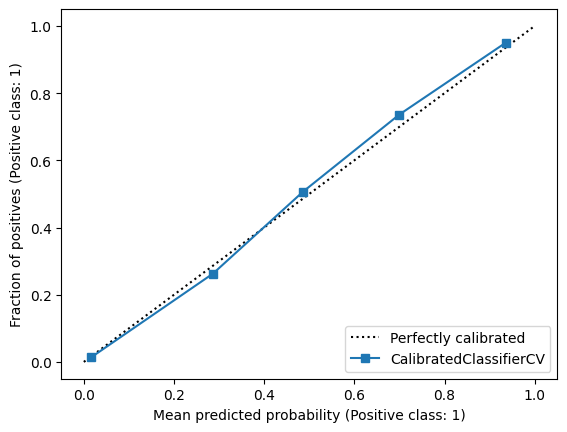

In [116]:
#calibrate the predictions
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt


model_clf = CalibratedClassifierCV(
    estimator = pipe_clf,
    cv = 2, method ='isotonic')

model_clf.fit(train[INPUT_FEATURES_CHURN], y_train_churn)

#plot the curve
disp = CalibrationDisplay.from_estimator(
    model_clf,
    valid[INPUT_FEATURES_CHURN],
    y_valid_churn)

plt.show()

In [117]:
y_pred_churn_train = pipe_clf.predict_proba(train[INPUT_FEATURES_CHURN])[:, 1]
y_pred_churn_valid = pipe_clf.predict_proba(valid[INPUT_FEATURES_CHURN])[:, 1]
metric_for_churn(y_train_churn, y_pred_churn_train), metric_for_churn(y_valid_churn, y_pred_churn_valid)

(np.float64(0.979), np.float64(0.974))

In [118]:
#cleck the scores for the calibrated model
y_pred_churn_train = model_clf.predict_proba(train[INPUT_FEATURES_CHURN])[:, 1]
y_pred_churn_valid = model_clf.predict_proba(valid[INPUT_FEATURES_CHURN])[:, 1]
metric_for_churn(y_train_churn, y_pred_churn_train), metric_for_churn(y_valid_churn, y_pred_churn_valid)

(np.float64(0.979), np.float64(0.974))

In [119]:
train_all['__churn_prob'] = pipe_clf.predict_proba(train_all[INPUT_FEATURES_CHURN])[:, 1]
train['__churn_prob'] = pipe_clf.predict_proba(train[INPUT_FEATURES_CHURN])[:, 1]
valid['__churn_prob'] = pipe_clf.predict_proba(valid[INPUT_FEATURES_CHURN])[:, 1]
test['__churn_prob'] = pipe_clf.predict_proba(test[INPUT_FEATURES_CHURN])[:, 1]

### Pipeline PRICE_DOC

In [120]:
#select categorical and numerical data
categorical_cols_ = train[INPUT_FEATURES_PRICE].select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols_ = train[INPUT_FEATURES_PRICE].select_dtypes(include=['int64', 'float64']).columns.tolist()

In [121]:

#create a pipeline for categorical data

categorical_pipeline_ = Pipeline([
    ('imputer', SimpleImputer(strategy= 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output = False)),
])

#create a numerical pipeline
numerical_pipeline_ = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', QuantileTransformer(output_distribution='normal')),

])



In [122]:
#set up the transformer
col_transformer_ = ColumnTransformer(transformers =[
    ('categorical', categorical_pipeline_, categorical_cols_),
    ('numerical', numerical_pipeline_, numerical_cols_)
])

In [123]:
# fit the transformer pipeline
col_transformer_.fit(train[INPUT_FEATURES_PRICE], y_train_price)

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['culture_objects_top_25']),
                                ('numerical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler',
                                                  QuantileTransformer(output_distribution='normal'))]...
                                  'public_transport_station_min_walk',
                                  'leisure_count_3000', 'total_ct_chng_q4_q1',
                                  'cafe_sum_1000_min_price_avg', 'max_floor',
                                  'build_year', 'state', 'life_sq',
                                  'office_sqm_5000', 'leisure_count_5000',
                                  'sport_count_2000',
                                  'railroad_station_walk_km',
                                  'detention_facility_km', 'trc_count_2000',
                                  'cafe_count_1000_price_1000', 'metro_km_walk',
                                  '0_17_all', 'cafe_sum_1500_min_price_avg'])])

In [124]:
!pip install catboost

In [125]:
from catboost import CatBoostRegressor
CB_reg = CatBoostRegressor(random_state=47, max_depth = 7, learning_rate = 0.05 )

In [126]:
pipe_reg = make_pipeline(col_transformer_ , CB_reg)

In [127]:
# fit pipeline
pipe_reg.fit(train[INPUT_FEATURES_PRICE], y_train_price)

0:	learn: 4.4368494	total: 45.8ms	remaining: 45.8s
1:	learn: 4.3432171	total: 81.6ms	remaining: 40.7s
2:	learn: 4.2567688	total: 124ms	remaining: 41.2s
3:	learn: 4.1782002	total: 173ms	remaining: 43.1s
4:	learn: 4.0990505	total: 234ms	remaining: 46.5s
5:	learn: 4.0276235	total: 281ms	remaining: 46.5s
6:	learn: 3.9574786	total: 330ms	remaining: 46.9s
7:	learn: 3.8932632	total: 366ms	remaining: 45.3s
8:	learn: 3.8342548	total: 398ms	remaining: 43.9s
9:	learn: 3.7737858	total: 427ms	remaining: 42.3s
10:	learn: 3.7190153	total: 451ms	remaining: 40.5s
11:	learn: 3.6711112	total: 470ms	remaining: 38.7s
12:	learn: 3.6192479	total: 493ms	remaining: 37.4s
13:	learn: 3.5741137	total: 507ms	remaining: 35.7s
14:	learn: 3.5323786	total: 515ms	remaining: 33.8s
15:	learn: 3.4897072	total: 523ms	remaining: 32.2s
16:	learn: 3.4477418	total: 531ms	remaining: 30.7s
17:	learn: 3.4103650	total: 542ms	remaining: 29.6s
18:	learn: 3.3769208	total: 569ms	remaining: 29.4s
19:	learn: 3.3490450	total: 595ms	remai

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['culture_objects_top_25']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   QuantileTransf...
                                                   'cafe_sum_1000_min_price_avg',
                                                   'max_floor', 'build_year',
                                                   'state', 'life_sq',
                                                   'office_sqm_5000',
                                                   'leisure_count_5000',
                                                   'sport_count_2000',
                                                   'railroad_station_walk_km',
                                                   'detention_facility_km',
                                                   'trc_count_2000',
                                                   'cafe_count_1000_price_1000',
                                                   'metro_km_walk', '0_17_all',
                                                   'cafe_sum_1500_min_price_avg'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x7ced8ce30690>)])

In [128]:
y_pred_price_train = pipe_reg.predict(train[INPUT_FEATURES_PRICE])
y_pred_price_valid = pipe_reg.predict(valid[INPUT_FEATURES_PRICE])
metric_for_price(y_train_price, y_pred_price_train), metric_for_price(y_valid_price, y_pred_price_valid)

(-0.094, -0.134)

In [129]:
train_all['__price_predict'] = pipe_reg.predict(train_all[INPUT_FEATURES_PRICE])
train['__price_predict'] = pipe_reg.predict(train[INPUT_FEATURES_PRICE])
valid['__price_predict'] = pipe_reg.predict(valid[INPUT_FEATURES_PRICE])
test['__price_predict'] = pipe_reg.predict(test[INPUT_FEATURES_PRICE])

### Improve algorithm

In [145]:
def alg1(x):
    '''if the probability of defaulting on a loan is less than 20%
then we can issue the loan at a certain __price_predict '''
    if x['__churn_prob'] < 0.2:

        return x['__price_predict']

# column __price_predict must be in train and test dataset
train_all['__priority'] = train_all.apply(alg1, axis=1)
train['__priority'] = train.apply(alg1, axis=1)
valid['__priority'] = valid.apply(alg1, axis=1)
test['__priority'] = test.apply(alg1, axis=1)

### Calculate quality metrics

In [146]:
from sklearn.model_selection import train_test_split

metrics = pd.DataFrame(data=[calc_all_metrics(train),
                             calc_all_metrics(valid)],
                       index=['train', 'valid']).T
metrics

,train,valid
total_profit,10132.560,5696.760
%profit_issued,40.500,22.800
%issued_loans,99.990,99.980
issued_loans,24997.290,24994.900
count_good,3142.000,4003.000
count_bad,38.000,286.000
%bad,1.200,6.700
churn_auc,0.979,0.974
price_nmsle,-0.094,-0.134
price_mape,-0.363,-0.449


In [132]:
num_features_clf = pipe_clf[:-1].transform(train_all[INPUT_FEATURES_CHURN]).columns.shape
num_features_clf

(23,)

In [133]:
num_features_reg = pipe_reg[:-1].transform(train_all[INPUT_FEATURES_PRICE]).columns.shape
num_features_reg

(22,)

In [134]:
# calculate total number of features
num_total = num_features_clf[0] + num_features_reg[0]
num_total

45

In [135]:
metric_for_churn(train_all['__churn'], train_all['__churn_prob'])

np.float64(0.977)

In [136]:
metric_for_price(train_all['__price_doc'], train_all['__price_predict'])

-0.114

In [147]:
calc_all_metrics(train_all, max_account=50_000)

{'total_profit': np.float64(19110.99),
 '%profit_issued': np.float64(38.2),
 '%issued_loans': np.float64(100.0),
 'issued_loans': np.float64(49999.88),
 'count_good': np.int64(7237),
 'count_bad': np.int64(96),
 '%bad': np.float64(1.3),
 'churn_auc': np.float64(0.977),
 'price_nmsle': -0.114,
 'price_mape': -0.406}

In [148]:
# this columns must be in dataset
prediction_columns = ['__price_predict', '__churn_prob', '__priority']

if train_all.shape[0] != TRAIN_SHAPE[0]:
    raise ValueError(f'Incorrect train file shape. Original {TRAIN_SHAPE[0]}. {train_all.shape[0]} are given')

for col in prediction_columns:
    if col not in train_all.columns.tolist():
        raise ValueError(f"{col} does not exist in train dataset")

# select top_features and predition columns only
train_all_top = train_all[prediction_columns]
# index must be True
train_all_top.to_csv('/content/5_' + NAME + '_train.csv', index=True)

if test.shape[0] != TEST_SHAPE[0]:
    raise ValueError(f'Incorrect test file shape. Original {TEST_SHAPE[0]}. {test.shape[0]} are given')

for col in prediction_columns:
    if col not in test.columns.tolist():
        raise ValueError(f"{col} does not exist in test dataset")

# select top_features and predition columns only
test_top = test[prediction_columns]
# index must be True
test_top.to_csv('/content/5_' + NAME + '_test.csv', index=True)

print(train_all_top.shape, test_top.shape)

(20483, 3) (9183, 3)
